In [9]:
import pandas as pd
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np


###### ArCo ARMADO DE LA BASE#######
import os
from typing import List
from datetime import datetime

# Establecer el directorio de trabajo - DNP
#os.chdir("C:/Users/supegui/Documents/Metodología ArCo/Python/Excel")

# Establecer el directorio de trabajo - Remoto
os.chdir("C:/Backup - Archivos de trabajo/DNP/Automatización ArCo/Excel")

# Saca la lista de archivos del directorio de trabajo
#os.listdir()
# Obtener la fecha actual
fecha_actual = datetime.now().strftime("%Y %m %d")
#print(fecha_actual)

# Construir el nombre del archivo basado en la fecha actual
#nombre_archivo = f"{fecha_actual} Informe ArCo.xlsx"

# Construir el nombre del archivo cuando la fecha no es la actual. Aquí solo se modifica la fecha. 
#nombre_archivo = "2024 10 30 - Base Original.xlsx"
nombre_archivo = "2024 11 07 - Base ArCo Regional Original.xlsx"

In [11]:
data_arco = pd.read_excel(nombre_archivo, sheet_name="Sheet1")

In [10]:
data_arco.head()

data_arco.shape


(13, 66)

In [5]:
# Tipos de usuario, apoyo y objetivos que mencionaste
tipos_usuario = ["Emprendedores", "Mipymes", "Grandes empresas", "Gobierno ",
                 "Academia", "Entidades de soporte", "Personas naturales"]

tipos_apoyo = ['Formación de Talento Humano', 'Tipo de Sistemas de Información', 
               'Asistencia técnica y Consultoría', 'Tipo de Redes de Colaboración', 
               'Apoyo Financiero', 'Incentivos Tributarios', 'Eventos', 'Compra Pública', 
               'Bonos o Vouchers', 'Premios y Reconocimientos', 'Instrumentos Regulatorios']

objetivos_politica = ["Innovación", "Emprendimiento", "Economía Popular",
                      "Transferencia de Conocimiento y Tecnología", "Investigación",
                      "Formación de Capital Humano", "Propiedad intelectual", "Calidad",
                      "Clúster o encadenamientos", "Financiación", "Comercialización",
                      "Formalización", "Crecimiento Sostenible", "Inclusión Financiera",
                      "Comercio Electrónico", "Educación económica y financiera", 
                      "Competencias Digitales"]


In [6]:
lista_variables_mipymes = ['Código', 'Nombre del Instrumento', 'Mipymes']
mi_pymes_arco = data_arco.loc[data_arco['Mipymes'] == 'Si', lista_variables_mipymes] 
#print(mi_pymes_arco)


lista_variables_gran_empresa = ['Código', 'Nombre del Instrumento', 'Grandes empresas']
gran_empresa_arco = data_arco.loc[data_arco['Grandes empresas'] == 'Si', lista_variables_gran_empresa] 
#print(gran_empresa_arco)

lista_variables_gobierno = ['Código', 'Nombre del Instrumento', 'Gobierno ']
gobierno_arco = data_arco.loc[data_arco['Gobierno '] == 'Si', lista_variables_gobierno] 
#print(gobierno_arco)

lista_variables_academia = ['Código', 'Nombre del Instrumento', 'Academia']
academia_arco = data_arco.loc[data_arco['Academia'] == 'Si', lista_variables_academia] 
#print(academia_arco)

# Unión de variables

grandes_empresas_mipymes_merge = pd.merge(mi_pymes_arco, gran_empresa_arco, how="left", on=["Código", "Código"])

gobierno_academia = pd.merge(gobierno_arco, academia_arco, how="left", on=["Código", "Código"])

#grandes_empresas_mipymes_merge.to_excel('C:/Users/supegui/Documents/Metodología ArCo/Python/Excel/prueba_union_Y.xlsx', index=False)
#print(gobierno_academia)



In [15]:
# 1. Primero, creamos una matriz de características binarias para cada instrumento
def crear_matriz_caracteristicas(data_arco):
    # Seleccionamos las columnas relevantes
    cols_usuarios = ['Mipymes', 'Grandes empresas', 'Gobierno ', 'Academia']
    
    # Creamos una matriz donde cada fila es un instrumento y cada columna es un tipo de usuario
    matriz_caracteristicas = data_arco[cols_usuarios].copy()
    
    # Convertimos 'Si'/'No' a 1/0
    matriz_caracteristicas = (matriz_caracteristicas == 'Si').astype(int)
    
    return matriz_caracteristicas


In [16]:
# 2. Calculamos la similitud entre instrumentos
def calcular_similitud(data_arco):
    # Obtenemos la matriz de características
    matriz = crear_matriz_caracteristicas(data_arco)
    
    # Inicializamos la matriz de similitud
    n_instrumentos = len(data_arco)
    matriz_similitud = np.zeros((n_instrumentos, n_instrumentos))
    
    # Calculamos la similitud para cada par de instrumentos
    for i in range(n_instrumentos):
        for j in range(n_instrumentos):
            # Extraemos los vectores de características para los instrumentos i y j
            instrumento_i = matriz.iloc[i].values
            instrumento_j = matriz.iloc[j].values
            
            # Calculamos similitud usando coincidencias
            coincidencias = sum(instrumento_i & instrumento_j)  # AND lógico
            total_usuarios = sum(instrumento_i | instrumento_j)  # OR lógico
            
            # Calculamos el coeficiente de Jaccard
            if total_usuarios > 0:
                similitud = coincidencias / total_usuarios
            else:
                similitud = 0
                
            matriz_similitud[i][j] = similitud
    
    return matriz_similitud



In [20]:
# 3. Convertimos la similitud a ratings
def calcular_ratings(data_arco):
    # Calculamos la matriz de similitud
    matriz_similitud = calcular_similitud(data_arco)
    
    # Creamos un DataFrame con los ratings
    ratings = []
    
    for i in range(len(matriz_similitud)):
        for j in range(len(matriz_similitud)):
            if i != j:  # No incluimos la similitud de un instrumento consigo mismo
                ratings.append({
                    'Instrumento_A': data_arco.iloc[i]['Código'],
                    'Nombre_A': data_arco.iloc[i]['Nombre del Instrumento'],
                    'Instrumento_B': data_arco.iloc[j]['Código'],
                    'Nombre_B': data_arco.iloc[j]['Nombre del Instrumento'],
                    'Rating': round(matriz_similitud[i][j] * 5, 2)  # Convertimos a escala 0-5
                })
    
    df_ratings = pd.DataFrame(ratings)
    
    # Ordenamos por rating de mayor a menor
    df_ratings = df_ratings.sort_values('Rating', ascending=False)
    
    return df_ratings

In [26]:
df_ratings = calcular_ratings(data_arco)
print(df_ratings)  # Ahora sí debería funcionar

        Instrumento_A                                           Nombre_A  \
55886             766  Servicios de asistencia técnica, para el forta...   
147755           3562    Estrategia Articular + Prevenir = Futuro Seguro   
147740           3562    Estrategia Articular + Prevenir = Futuro Seguro   
147745           3562    Estrategia Articular + Prevenir = Futuro Seguro   
138448           2969  AMPLIACIÓN DEL CONOCIMIENTO DE LOS RECURSOS MI...   
...               ...                                                ...   
76707            1732  Calidad para la Reindustrialización - Asistenc...   
76705            1732  Calidad para la Reindustrialización - Asistenc...   
76703            1732  Calidad para la Reindustrialización - Asistenc...   
76702            1732  Calidad para la Reindustrialización - Asistenc...   
174305           3711  Estrategia de Alimentos de Alto Valor Nutricional   

        Instrumento_B                                           Nombre_B  \
55886      

In [27]:
# 4. Función principal que integra todo el proceso
def generar_ratings_colaborativos(data_arco):
    # Calculamos los ratings
    df_ratings = calcular_ratings(data_arco)
    
    # Filtramos solo los pares con rating significativo (por ejemplo, mayor a 2)
    df_ratings_significativos = df_ratings[df_ratings['Rating'] > 2]
    
    return df_ratings_significativos

# Ejemplo de uso:
#ratings_finales = generar_ratings_colaborativos(data_arco)
#print(ratings_finales.head(10))


In [70]:
ratings_finales.to_excel('C:/Users/supegui/Documents/Metodología ArCo/Python/Excel/recomendaciones_X.xlsx')

In [29]:
df_ratings.head(100000)


,Instrumento_A,Nombre_A,Instrumento_B,Nombre_B,Rating
55886,766,"Servicios de asistencia técnica, para el forta...",358,Asesoría y capacitación:Plan Vial; inventario ...,5.0
147755,3562,Estrategia Articular + Prevenir = Futuro Seguro,773,Proyecto Tipo Mejoramiento de vías terciarias ...,5.0
147740,3562,Estrategia Articular + Prevenir = Futuro Seguro,731,Gestión de destinos turísticos,5.0
147745,3562,Estrategia Articular + Prevenir = Futuro Seguro,742,Asesorías en la formulación de proyectos de in...,5.0
138448,2969,AMPLIACIÓN DEL CONOCIMIENTO DE LOS RECURSOS MI...,343,Información del proceso de Reintegración y Rei...,5.0
...,...,...,...,...,...
137456,2958,Investigación sobre amenazas y riesgos geológi...,2448,Mujer Rural,0.0
137455,2958,Investigación sobre amenazas y riesgos geológi...,2447,Fomento a Proyectos e Iniciativas Productivas ...,0.0
137446,2958,Investigación sobre amenazas y riesgos geológi...,2428,Línea Especial de Microcrédito Inclusión Finan...,0.0
137443,2958,Investigación sobre amenazas y riesgos geológi...,2420,Jover Rural,0.0


In [31]:
df_ratings[df_ratings['Instrumento_B']==731]

,Instrumento_A,Nombre_A,Instrumento_B,Nombre_B,Rating
147740,3562,Estrategia Articular + Prevenir = Futuro Seguro,731,Gestión de destinos turísticos,5.0
15133,467,"Promoción de los derechos y deberes en salud, ...",731,Gestión de destinos turísticos,5.0
44323,676,Servicio de ecoturismo en las áreas protegidas,731,Gestión de destinos turísticos,5.0
118550,2774,Estrategia de Asesoría integral a las entidade...,731,Gestión de destinos turísticos,5.0
18052,486,Justicia en territorio para la paz total,731,Gestión de destinos turísticos,5.0
...,...,...,...,...,...
78518,1760,Ruta ALDEA,731,Gestión de destinos turísticos,0.0
78101,1758,Héroes Fest,731,Gestión de destinos turísticos,0.0
76433,1732,Calidad para la Reindustrialización - Asistenc...,731,Gestión de destinos turísticos,0.0
76016,1723,Convocatoria del Fondo para el Desarrollo Cine...,731,Gestión de destinos turísticos,0.0


In [33]:
import pandas as pd
import numpy as np
from surprise import Dataset, Reader, SVD, KNNBasic, NMF, accuracy, similarities
from surprise.model_selection import train_test_split, cross_validate
from collections import defaultdict

class SistemaRecomendacion:
    def __init__(self, df_ratings):
        """
        Inicializa el sistema de recomendación con el DataFrame de ratings
        """
        self.df_ratings = df_ratings
        
        # Aseguramos que los ratings están en el rango correcto
        self.df_ratings['Rating'] = self.df_ratings['Rating'].clip(0, 5)
        
        # Configuramos el reader con un rango válido
        self.reader = Reader(rating_scale=(0, 5))
        
        # Convertimos a formato Surprise
        self.data = Dataset.load_from_df(
            self.df_ratings[['Instrumento_A', 'Instrumento_B', 'Rating']], 
            self.reader
        )
        
        # Definimos los modelos con configuraciones más robustas
        self.modelos = {
            'SVD': SVD(
                n_factors=50,  # Reducido para evitar overfitting
                n_epochs=20,
                lr_all=0.005,
                reg_all=0.02,
                random_state=42
            ),
            'NMF': NMF(
                n_factors=15,
                n_epochs=50,
                random_state=42
            )
        }
        
        # Agregamos KNN solo si tenemos suficientes datos
        if len(df_ratings) > 10:  # umbral arbitrario, ajustar según necesidad
            self.modelos['KNN'] = KNNBasic(
                k=min(40, len(df_ratings) - 1),  # k no puede ser mayor que n-1
                min_k=1,
                sim_options={
                    'name': 'cosine',  # cambiamos a similitud coseno que es más robusta
                    'user_based': False,
                    'min_support': 1  # número mínimo de ratings en común
                }
            )
        
        self.mejor_modelo = None
        self.metricas_modelos = {}

    def evaluar_modelos(self):
        """
        Evalúa diferentes modelos usando validación cruzada con manejo de errores
        """
        print("Evaluando modelos...")
        for nombre, modelo in self.modelos.items():
            try:
                # Realizar validación cruzada con menos folds si hay pocos datos
                n_folds = min(5, len(self.df_ratings) // 2)
                n_folds = max(2, n_folds)  # al menos 2 folds
                
                resultados = cross_validate(
                    modelo, 
                    self.data, 
                    measures=['RMSE', 'MAE'], 
                    cv=n_folds, 
                    verbose=False
                )
                
                self.metricas_modelos[nombre] = {
                    'RMSE_medio': np.mean(resultados['test_rmse']),
                    'MAE_medio': np.mean(resultados['test_mae']),
                    'tiempo_fit_medio': np.mean(resultados['fit_time']),
                    'tiempo_test_medio': np.mean(resultados['test_time'])
                }
                
            except Exception as e:
                print(f"Error evaluando modelo {nombre}: {str(e)}")
                continue
        
        if not self.metricas_modelos:
            raise ValueError("Ningún modelo pudo ser evaluado exitosamente")
            
        # Encontrar el mejor modelo basado en RMSE
        mejor_modelo_nombre = min(
            self.metricas_modelos, 
            key=lambda x: self.metricas_modelos[x]['RMSE_medio']
        )
        self.mejor_modelo = self.modelos[mejor_modelo_nombre]
        
        return self.metricas_modelos

    def entrenar_mejor_modelo(self):
        """
        Entrena el mejor modelo con todos los datos
        """
        if self.mejor_modelo is None:
            raise ValueError("Debe evaluar los modelos primero")
            
        trainset = self.data.build_full_trainset()
        self.mejor_modelo.fit(trainset)

    def generar_recomendaciones(self, instrumento_id, n=5):
        """
        Genera recomendaciones para un instrumento específico con manejo de errores
        """
        if self.mejor_modelo is None:
            raise ValueError("Debe entrenar el modelo primero")
            
        # Obtener todos los instrumentos únicos
        instrumentos_unicos = set(self.df_ratings['Instrumento_A'].unique()) | \
                            set(self.df_ratings['Instrumento_B'].unique())
        
        if instrumento_id not in instrumentos_unicos:
            raise ValueError(f"Instrumento {instrumento_id} no encontrado en el conjunto de datos")
        
        # Generar predicciones para todos los pares posibles
        predicciones = []
        for otro_instrumento in instrumentos_unicos:
            if otro_instrumento != instrumento_id:
                try:
                    pred = self.mejor_modelo.predict(instrumento_id, otro_instrumento)
                    predicciones.append({
                        'Instrumento_origen': instrumento_id,
                        'Instrumento_recomendado': otro_instrumento,
                        'Rating_predicho': pred.est,
                        'Detalles': pred.details
                    })
                except Exception as e:
                    print(f"Error prediciendo para {otro_instrumento}: {str(e)}")
                    continue
        
        if not predicciones:
            raise ValueError("No se pudieron generar predicciones")
            
        # Convertir a DataFrame y ordenar
        df_recomendaciones = pd.DataFrame(predicciones)
        df_recomendaciones = df_recomendaciones.sort_values(
            'Rating_predicho', 
            ascending=False
        ).head(n)
        
        return df_recomendaciones

    def mostrar_metricas(self):
        """
        Muestra las métricas de evaluación de todos los modelos
        """
        if not self.metricas_modelos:
            raise ValueError("No hay métricas disponibles. Debe evaluar los modelos primero")
            
        df_metricas = pd.DataFrame(self.metricas_modelos).round(4)
        return df_metricas.transpose()

def crear_y_evaluar_sistema(df_ratings):
    """
    Función principal para crear y evaluar el sistema de recomendación
    """
    # Verificar que tenemos suficientes datos
    if len(df_ratings) < 5:
        raise ValueError("Se necesitan al menos 5 ratings para crear el sistema")
        
    # Verificar que tenemos variabilidad en los ratings
    if df_ratings['Rating'].std() < 0.1:
        raise ValueError("No hay suficiente variabilidad en los ratings")
        
    # Crear sistema
    sistema = SistemaRecomendacion(df_ratings)
    
    # Evaluar modelos
    try:
        metricas = sistema.evaluar_modelos()
        print("\nMétricas de evaluación:")
        print(sistema.mostrar_metricas())
        
        # Entrenar mejor modelo
        sistema.entrenar_mejor_modelo()
        
    except Exception as e:
        print(f"Error en la evaluación del sistema: {str(e)}")
        raise
    
    return sistema

# Ejemplo de uso:

try:
    # Crear y evaluar el sistema
    sistema = crear_y_evaluar_sistema(df_ratings)
    
    # Generar recomendaciones para un instrumento específico
    instrumento_ejemplo = df_ratings['Instrumento_A'].iloc[126]
    recomendaciones = sistema.generar_recomendaciones(instrumento_ejemplo, n=20)
    print("\nRecomendaciones para instrumento", instrumento_ejemplo)
    print(recomendaciones)
    
except Exception as e:
    print(f"Error: {str(e)}")



Evaluando modelos...
Computing the cosine similarity matrix...
Error evaluando modelo KNN: float division

Métricas de evaluación:
     RMSE_medio  MAE_medio  tiempo_fit_medio  tiempo_test_medio
SVD      0.1226      0.056            0.5532             0.1320
NMF      0.1875      0.071            1.0728             0.1227

Recomendaciones para instrumento 2792
     Instrumento_origen  Instrumento_recomendado  Rating_predicho  \
349                2792                     3644         3.541778   
298                2792                     3505         3.515281   
352                2792                     3648         3.510374   
22                 2792                     2352         3.507910   
293                2792                     3489         3.506192   
305                2792                     3548         3.502047   
220                2792                     2820         3.495974   
161                2792                      636         3.494253   
194              

## Análisis - Tipos de usuarios 

In [5]:
from sklearn.metrics.pairwise import cosine_similarity
import seaborn as sns
import matplotlib.pyplot as plt

#2022
# Set working directory
#os.chdir("C:/Backup - Archivos de trabajo/DNP/Automatización ArCo/Excel/Filtro colaborativo/Excel")

# Import data
#data = pd.read_excel("Base 2022.xlsx", sheet_name="Microdato")

C:\Users\sebas\AppData\Local\Temp\ipykernel_26436\2974591370.py:16: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  return df[columns].applymap(lambda x: 1 if x in ["Si", np.nan] else 0)



Tipos de usuario para 'Fábricas de Productividad y Sostenibilidad - Huila':
- Microempresa
- Pequeña Empresa
- Mediana Empresa
- Gobierno 
- Academia

Instrumentos más similares a 'Fábricas de Productividad y Sostenibilidad - Huila' según tipo de usuario:
                                                                                                                                           Instrumento Similitud                                                                        Tipos de Usuario
                                                                                                                                          Convocatoria   100.00%                     Microempresa, Pequeña Empresa, Mediana Empresa, Gobierno , Academia
                                                                                     CELEBRACIÓN DEL DÍA DEL CAMPESINO DEL MUNICIPIO DE LA PLATA HUILA    91.29% Microempresa, Pequeña Empresa, Mediana Empresa, Gobierno , Academia, Personas natura

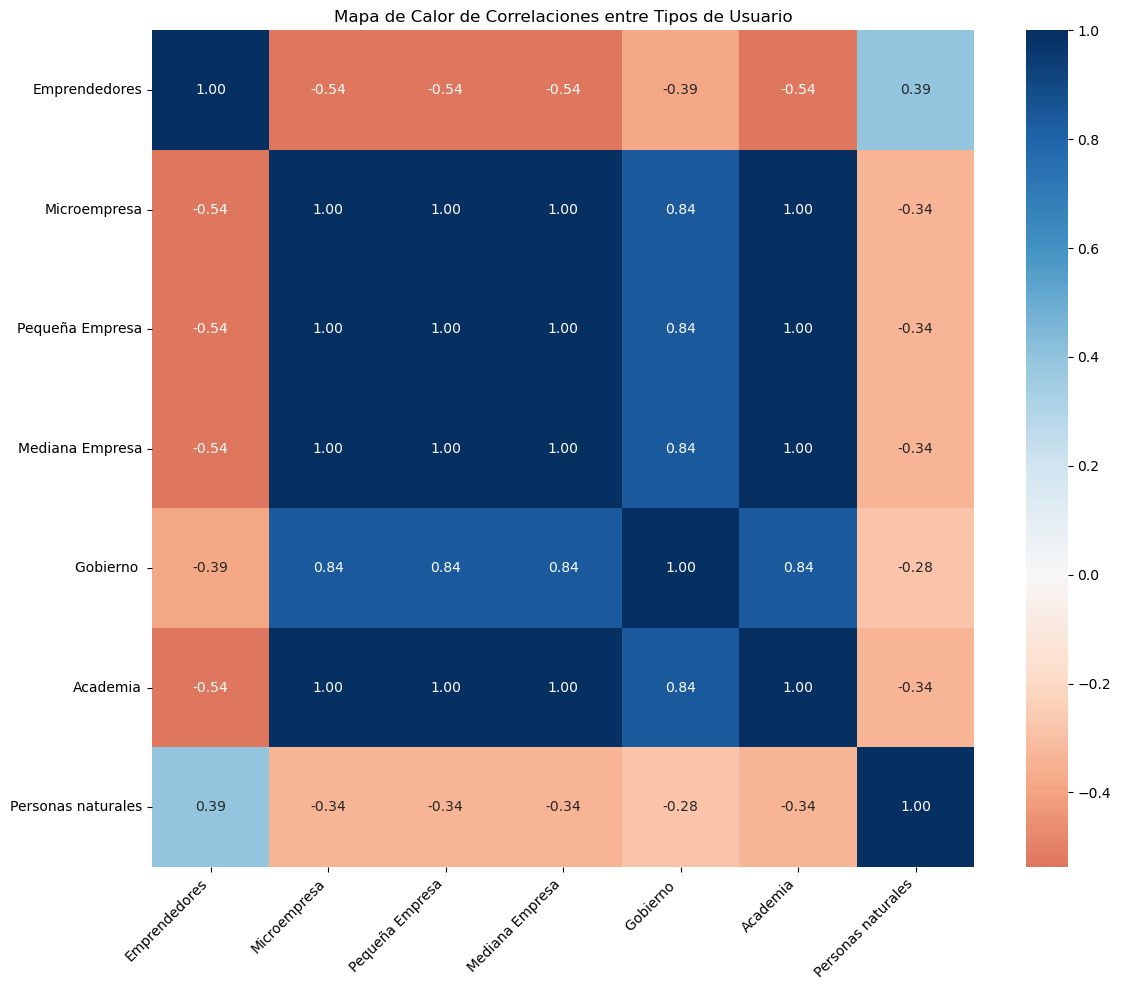


Estadísticas de correlaciones:
Correlación promedio: 0.267
Correlación máxima: 1.000
Correlación mínima: -0.537

Distribución de correlaciones:
Rango
Muy negativa          4
Negativa moderada     5
Negativa débil        1
Sin correlación       0
Positiva débil        0
Positiva moderada     1
Positiva fuerte      10
Name: count, dtype: int64


In [17]:
"""import pandas as pd
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
import os
import seaborn as sns
import matplotlib.pyplot as plt
"""
# Set working directory
#os.chdir("C:/Backup - Archivos de trabajo/DNP/Automatización ArCo/Excel/Filtro colaborativo/Excel")

# Import data
#data = pd.read_excel("Base 2022.xlsx")

# Prepare data for user type
def prepare_data(df, columns):
    return df[columns].applymap(lambda x: 1 if x in ["Si", np.nan] else 0)

"""
# Prepare user type matrix - 2022
user_type_columns = [
    "Emprendedor", 
    "MiPymes", 
    "Grandes empresas", 
    "Gobierno", 
    "Academia", 
    "Entidades de Soporte ", 
    "Personas Naturales"
]
"""



"""# Prepare user type matrix - 2023
user_type_columns = [
    "Emprendedores", 
    "Mipymes", 
    "Grandes empresas", 
    "Gobierno ", 
    "Academia", 
    "Entidades de soporte", 
    "Personas naturales"
]
"""


"""# Prepare user type matrix - 2024
user_type_columns = [
    "Emprendedores", 
    "Mipymes", 
    "Grandes empresas", 
    "Gobierno ", 
    "Academia", 
    "Entidades de soporte", 
    "Personas naturales"
]
"""


# Prepare user type matrix - 2025
user_type_columns = [
    "Emprendedores", 
    "Microempresa",
    "Pequeña Empresa",
    "Mediana Empresa",
    #"Mipymes", 
    #"Grandes empresas", 
    "Gobierno ", 
    "Academia", 
    #"Entidades de soporte", 
    "Personas naturales"
]

tip_usu = prepare_data(data_arco, user_type_columns)

def get_similar_by_user_type(instrument_name, top_n=5):
    """
    Encuentra instrumentos similares basados en el tipo de usuario.
    
    Parameters:
    instrument_name (str): Nombre del instrumento a comparar
    top_n (int): Número de recomendaciones a devolver
    
    Returns:
    DataFrame: Top N instrumentos similares con sus puntuaciones y detalles
    """
    # Verificar si el instrumento existe 
    if instrument_name not in data_arco['Nombre del Instrumento'].values:
        return f"El instrumento '{instrument_name}' no se encuentra en la base de datos."
    
    # Obtener el índice del instrumento
    idx = data_arco[data_arco['Nombre del Instrumento'] == instrument_name].index[0]
    
    # Calcular matriz de similitud
    sim_matrix = cosine_similarity(tip_usu)
    
    # Obtener similitudes para el instrumento específico
    sim_scores = list(enumerate(sim_matrix[idx]))
    
    # Filtrar el instrumento mismo y ordenar por similitud
    sim_scores = [x for x in sim_scores if x[0] != idx]
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    
    # Obtener los top N más similares
    top_indices = [x[0] for x in sim_scores[:top_n]]
    top_scores = [x[1] for x in sim_scores[:top_n]]
    
    # Crear DataFrame con resultados detallados
    recommendations = pd.DataFrame({
        'Instrumento': data_arco['Nombre del Instrumento'].iloc[top_indices],
        'Puntuación de Similitud': [f"{score:.2%}" for score in top_scores]
    })
    
    # Agregar detalles de tipos de usuario para el instrumento original
    print(f"\nTipos de usuario para '{instrument_name}':")
    original_users = tip_usu.iloc[idx]
    for col, val in original_users.items():
        if val == 1:
            print(f"- {col}")
    
    # Agregar detalles para cada recomendación
    detailed_recommendations = []
    for i, idx in enumerate(top_indices):
        instrument_data = {
            'Instrumento': data_arco['Nombre del Instrumento'].iloc[idx],
            'Similitud': f"{top_scores[i]:.2%}",
            'Tipos de Usuario': ', '.join([col for col, val in tip_usu.iloc[idx].items() if val == 1])
        }
        detailed_recommendations.append(instrument_data)
    
    detailed_df = pd.DataFrame(detailed_recommendations)
    
    return detailed_df

# Ejemplo de uso
instrumento = "Fábricas de Productividad y Sostenibilidad - Huila"
resultados = get_similar_by_user_type(instrumento)
print(f"\nInstrumentos más similares a '{instrumento}' según tipo de usuario:")
print(resultados.to_string(index=False))

# Análisis adicional de la matriz de tipos de usuario
print("\nEstadísticas de tipos de usuario:")
user_type_stats = tip_usu.sum().sort_values(ascending=False)
print("\nNúmero de instrumentos por tipo de usuario:")
for user_type, count in user_type_stats.items():
    print(f"{user_type}: {count}")

# Calcular correlaciones entre tipos de usuario
#correlations = tip_usu.corr()
#print("\nCorrelaciones más fuertes entre tipos de usuario:")
#for i in range(len(user_type_columns)):
#    for j in range(i+1, len(user_type_columns)):
#        corr = correlations.iloc[i,j]
#        if abs(corr) > 0.3:  # Mostrar solo correlaciones significativas
#            print(f"{user_type_columns[i]} - {user_type_columns[j]}: {corr:.3f}")4


# Calcular correlaciones
correlations = tip_usu.corr()

# Mostrar todas las correlaciones ordenadas de mayor a menor
correlations_list = []
for i in range(len(user_type_columns)):
    for j in range(i+1, len(user_type_columns)):
        corr = correlations.iloc[i,j]
        correlations_list.append({
            'Tipo 1': user_type_columns[i],
            'Tipo 2': user_type_columns[j],
            'Correlación': corr
        })

# Convertir a DataFrame y ordenar
corr_df = pd.DataFrame(correlations_list)
corr_df = corr_df.sort_values('Correlación', ascending=False)

print("Todas las correlaciones ordenadas de mayor a menor:")
print(corr_df.to_string(index=False))

# Crear un mapa de calor para visualizar las correlaciones
plt.figure(figsize=(12, 10))
sns.heatmap(correlations, 
            annot=True, 
            cmap='RdBu', 
            center=0,
            fmt='.2f',
            xticklabels=user_type_columns,
            yticklabels=user_type_columns)
plt.title('Mapa de Calor de Correlaciones entre Tipos de Usuario')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

# Análisis estadístico adicional
print("\nEstadísticas de correlaciones:")
print(f"Correlación promedio: {corr_df['Correlación'].mean():.3f}")
print(f"Correlación máxima: {corr_df['Correlación'].max():.3f}")
print(f"Correlación mínima: {corr_df['Correlación'].min():.3f}")

# Mostrar distribución de correlaciones por rangos
print("\nDistribución de correlaciones:")
ranges = [-1, -0.5, -0.3, -0.1, 0.1, 0.3, 0.5, 1]
labels = ['Muy negativa', 'Negativa moderada', 'Negativa débil', 
          'Sin correlación', 'Positiva débil', 'Positiva moderada', 'Positiva fuerte']
corr_df['Rango'] = pd.cut(corr_df['Correlación'], bins=ranges, labels=labels)
print(corr_df['Rango'].value_counts().sort_index())

In [47]:
import pandas as pd
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity

def calculate_all_similarities(data_arco, tip_usu):
    """
    Calcula la similitud entre todos los pares de instrumentos.
    
    Parameters:
    data_arco (DataFrame): DataFrame con la información de los instrumentos
    tip_usu (DataFrame): Matriz de tipos de usuario preparada
    
    Returns:
    DataFrame: DataFrame con todos los pares de instrumentos y sus similitudes
    """
    # Calcular matriz de similitud
    sim_matrix = cosine_similarity(tip_usu)
    
    # Crear lista para almacenar todos los pares
    similarity_pairs = []
    
    # Obtener nombres de instrumentos
    instrument_names = data_arco['Nombre del Instrumento'].values
    
    # Crear pares de similitud
    for i in range(len(sim_matrix)):
        for j in range(i + 1, len(sim_matrix)):  # Solo la mitad superior de la matriz
            similarity_pairs.append({
                'Instrumento1': instrument_names[i],
                'Instrumento2': instrument_names[j],
                'Similitud': sim_matrix[i][j]
            })
    
    # Convertir a DataFrame y ordenar por similitud
    similarity_df = pd.DataFrame(similarity_pairs)
    similarity_df = similarity_df.sort_values('Similitud', ascending=False)
    
    # Convertir similitud a porcentaje
    similarity_df['Similitud'] = similarity_df['Similitud'].apply(lambda x: f"{x:.2%}")
    
    return similarity_df

def create_rating_column(similarity_df, threshold=0.7):
    """
    Crea una columna de rating basada en los porcentajes de similitud.
    
    Parameters:
    similarity_df (DataFrame): DataFrame con los pares de similitud
    threshold (float): Umbral para considerar una similitud alta
    
    Returns:
    DataFrame: DataFrame original con la columna de rating añadida
    """
    # Convertir similitud de string a float
    similarity_df['Similitud_num'] = similarity_df['Similitud'].str.rstrip('%').astype(float) / 100
    
    # Crear columna de rating
    similarity_df['Rating'] = similarity_df['Similitud_num'].apply(
        lambda x: 5 if x >= threshold else round(x * 5 / threshold, 1)
    )
    
    # Eliminar columna auxiliar
    similarity_df = similarity_df.drop('Similitud_num', axis=1)
    
    return similarity_df

# Ejemplo de uso:
def main(data_arco, tip_usu):
    # Calcular todas las similitudes
    similarity_pairs = calculate_all_similarities(data_arco, tip_usu)
    
    # Añadir columna de rating
    similarity_pairs = create_rating_column(similarity_pairs)
    
    # Mostrar las primeras filas
    print("\nPrimeros pares de instrumentos con mayor similitud:")
    print(similarity_pairs.head(50).to_string(index=False))
    
    # Estadísticas básicas
    ratings = similarity_pairs['Rating'].describe()
    print("\nEstadísticas de los ratings:")
    print(ratings)
    
    return similarity_pairs

# Para ejecutar el código:
# similarity_results = main(data_arco, tip_usu)

In [48]:
# Para ejecutar el código:
similarity_results = main(data_arco, tip_usu)


Primeros pares de instrumentos con mayor similitud:
                                                                                                               Instrumento1                                                                                                                                           Instrumento2 Similitud  Rating
                                                                           Información estadística de la temática económica                                                                                                                 Registro Nacional del Derecho de Autor   100.00%     5.0
                                                                             Cuenta Satélite de Cultura y Economía Creativa                                                                                                                                       Portal INNOVAMOS   100.00%     5.0
                                                             Fomento

In [46]:
similarity_results['Rating']

similarity_results = similarity_results[(similarity_results['Rating'] >= 2) & (similarity_results['Rating'] <= 5)]

similarity_results.shape

similarity_results.head()

,Instrumento1,Instrumento2,Similitud,Rating
1172,Información estadística de la temática económica,Registro Nacional del Derecho de Autor,100.00%,5.0
14863,Cuenta Satélite de Cultura y Economía Creativa,Portal INNOVAMOS,100.00%,5.0
2158,Fomento de Innovación y Desarrollo Tecnológico...,Educación Financiera - Finagro Educa 2.0,100.00%,5.0
2159,Fomento de Innovación y Desarrollo Tecnológico...,Programa Nacional de Escuelas Taller,100.00%,5.0
47009,"Servicios de asistencia técnica, para el forta...",Sistema de seguimiento presupuestal - SEPRE,100.00%,5.0


In [55]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler

def calculate_correlation_based_rating(data_arco, tip_usu):
    """
    Calcula ratings basados en las correlaciones entre tipos de usuarios.
    
    Parameters:
    data_arco (DataFrame): DataFrame con la información de los instrumentos
    tip_usu (DataFrame): Matriz de tipos de usuario preparada
    
    Returns:
    DataFrame: DataFrame con los pares de instrumentos y sus ratings basados en correlación
    """
    # Calcular matriz de correlación entre tipos de usuario
    correlations = tip_usu.corr()
    
    # Crear lista para almacenar todos los pares
    correlation_pairs = []
    instrument_names = data_arco['Nombre del Instrumento'].values
    
    for i in range(len(tip_usu)):
        for j in range(i + 1, len(tip_usu)):
            # Obtener los perfiles de usuario de ambos instrumentos
            profile1 = tip_usu.iloc[i]
            profile2 = tip_usu.iloc[j]
            
            # Calcular score basado en correlaciones
            correlation_score = 0
            common_users = 0
            
            # Para cada par de tipos de usuario presentes en ambos instrumentos
            for type1 in user_type_columns:
                for type2 in user_type_columns:
                    if profile1[type1] == 1 and profile2[type2] == 1:
                        correlation_score += correlations.loc[type1, type2]
                        common_users += 1
            
            # Normalizar score por el número de usuarios comunes si existen
            final_score = correlation_score / common_users if common_users > 0 else 0
            
            correlation_pairs.append({
                'Instrumento1': instrument_names[i],
                'Instrumento2': instrument_names[j],
                'Score': final_score,
                'Usuarios_Comunes': common_users
            })
    
    # Convertir a DataFrame
    correlation_df = pd.DataFrame(correlation_pairs)
    
    # Normalizar scores a escala 1-5 usando MinMaxScaler
    scaler = MinMaxScaler(feature_range=(1, 5))
    correlation_df['Rating'] = scaler.fit_transform(
        correlation_df['Score'].values.reshape(-1, 1)
    ).round(1)
    
    # Ordenar por Rating descendente
    correlation_df = correlation_df.sort_values('Rating', ascending=False)
    
    return correlation_df

def analyze_ratings(correlation_df):
    """
    Analiza la distribución de ratings y proporciona estadísticas útiles.
    
    Parameters:
    correlation_df (DataFrame): DataFrame con los ratings calculados
    
    Returns:
    dict: Diccionario con estadísticas de los ratings
    """
    stats = {
        'basic_stats': correlation_df['Rating'].describe(),
        'distribution': correlation_df['Rating'].value_counts().sort_index(),
        'correlation_stats': {
            'mean_users_common': correlation_df['Usuarios_Comunes'].mean(),
            'max_users_common': correlation_df['Usuarios_Comunes'].max(),
            'min_users_common': correlation_df['Usuarios_Comunes'].min()
        }
    }
    
    return stats

def main_correlation_based(data_arco, tip_usu, user_type_columns):
    """
    Función principal que ejecuta todo el análisis basado en correlaciones.
    """
    # Calcular ratings basados en correlación
    correlation_results = calculate_correlation_based_rating(data_arco, tip_usu)
    
    # Analizar resultados
    stats = analyze_ratings(correlation_results)
    
    # Mostrar resultados
    print("\nPrimeros pares de instrumentos con mayores ratings basados en correlación:")
    print(correlation_results[['Instrumento1', 'Instrumento2', 'Rating', 'Usuarios_Comunes']]
          .head(10).to_string(index=False))
    
    print("\nEstadísticas básicas de los ratings:")
    print(stats['basic_stats'])
    
    print("\nDistribución de ratings:")
    print(stats['distribution'])
    
    print("\nEstadísticas de usuarios comunes:")
    for key, value in stats['correlation_stats'].items():
        print(f"{key}: {value:.2f}")
    
    return correlation_results, stats

# Ejemplo de uso:
#correlation_results, stats = main_correlation_based(data_arco, tip_usu, user_type_columns)

def compare_ratings(similarity_results, correlation_results):
    """
    Compara los ratings obtenidos por ambos métodos.
    
    Parameters:
    similarity_results (DataFrame): Resultados del método basado en similitud
    correlation_results (DataFrame): Resultados del método basado en correlación
    
    Returns:
    DataFrame: DataFrame con la comparación de ratings
    """
    # Crear identificadores únicos para cada par
    def create_pair_id(row):
        return tuple(sorted([row['Instrumento1'], row['Instrumento2']]))
    
    similarity_results['pair_id'] = similarity_results.apply(create_pair_id, axis=1)
    correlation_results['pair_id'] = correlation_results.apply(create_pair_id, axis=1)
    
    # Merge de los resultados
    comparison = pd.merge(
        similarity_results[['pair_id', 'Rating']].rename(columns={'Rating': 'Rating_Similitud'}),
        correlation_results[['pair_id', 'Rating']].rename(columns={'Rating': 'Rating_Correlacion'}),
        on='pair_id'
    )
    
    # Calcular diferencia
    comparison['Diferencia'] = comparison['Rating_Similitud'] - comparison['Rating_Correlacion']
    
    # Ordenar por diferencia absoluta
    comparison = comparison.sort_values('Diferencia', key=abs, ascending=False)
    
    return comparison

# Para comparar ambos métodos:
comparison = compare_ratings(similarity_results, correlation_results)

In [67]:
#print(correlation_results[['Instrumento1', 'Instrumento2', 'Rating']].to_string(index=False))
#print(correlation_results[['Instrumento1', 'Instrumento2', 'Rating', 'Score', 'Usuarios_Comunes']])
#print(similarity_results[['Instrumento1', 'Instrumento2', 'Rating']].to_string(index=False))
correlation_results[['Instrumento1', 'Instrumento2', 'Rating', 'Usuarios_Comunes']].to_csv('correlaciones_instrumentos.csv', index=False)




## Análisis Tipos de Apoyo

C:\Users\sebas\AppData\Local\Temp\ipykernel_26436\2870176790.py:16: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  return df[columns].applymap(lambda x: 1 if x in ["Si", np.nan] else 0)



Tipos de apoyo para 'Fábricas de Productividad y Sostenibilidad - Huila':
- Formación de Talento Humano
- Asistencia técnica y Consultoría
- Tipo de Redes de Colaboración

Instrumentos más similares a 'Fábricas de Productividad y Sostenibilidad - Huila' según tipo de apoyo:
                                                                                                                                           Instrumento Similitud                                                                                             Tipos de Apoyo
               FERIA EQUINA GRADO B EN SU VERSIÓN 185, MERCADO GANADERO, MUESTRA AGRO EMPRESARIAL, COMERCIAL DE TURISMO, MERCADO CAMPESINO EN EL MUNIC    66.67%                                        Formación de Talento Humano, Tipo de Redes de Colaboración, Eventos
VERSIÓN 184 DE LA FERIA GANADERA, MERCADO GANADERO, MUESTRA GANADERA, CONCURSO DE LA VACA LECHERA, MUESTRA AGRO EMPRESARIAL, DE TURISMO Y MERCADO CAMP    66.67%                            

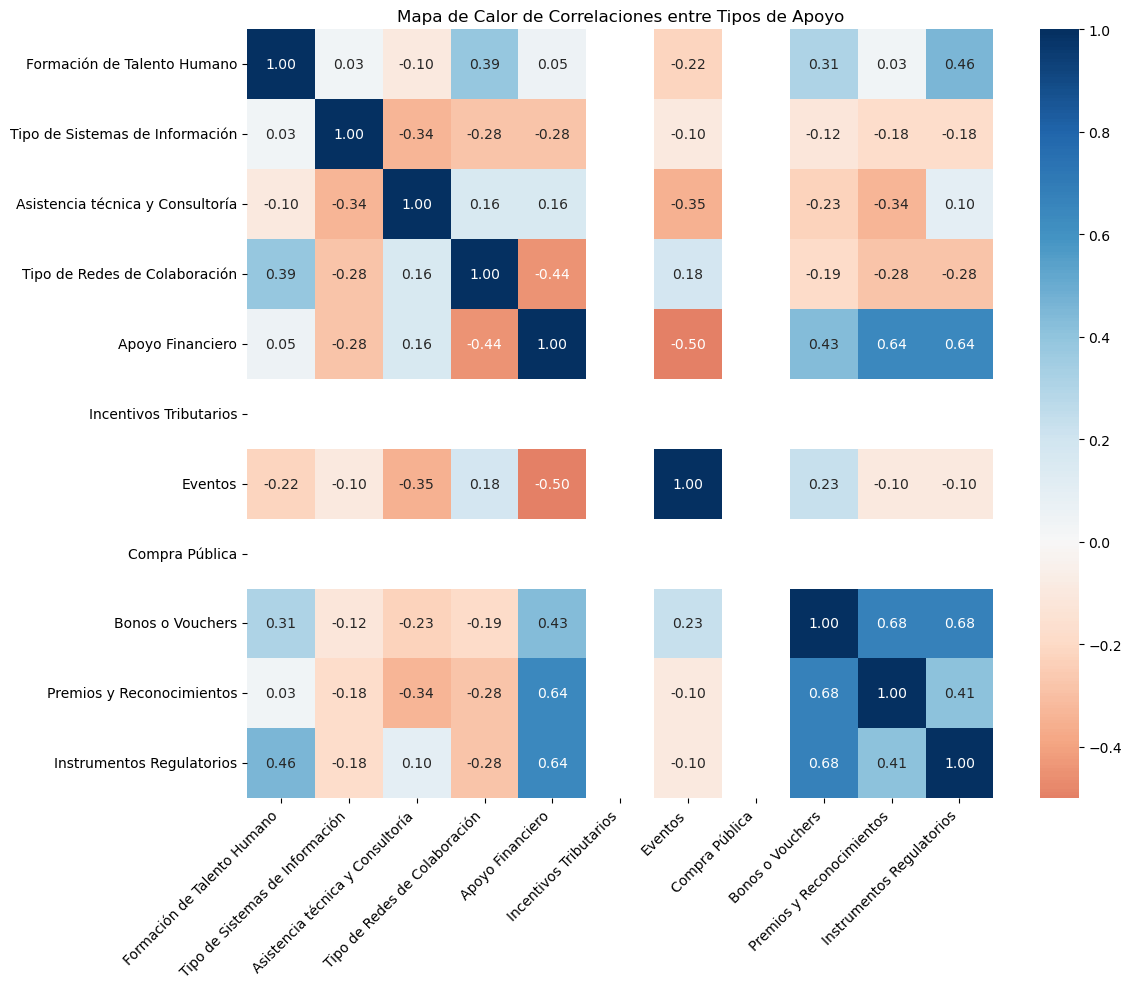


Estadísticas de correlaciones:
Correlación promedio: 0.026
Correlación máxima: 0.677
Correlación mínima: -0.501

Distribución de correlaciones:
Rango
Muy negativa          1
Negativa moderada     4
Negativa débil       13
Sin correlación       4
Positiva débil        5
Positiva moderada     5
Positiva fuerte       4
Name: count, dtype: int64


In [15]:
import matplotlib.pyplot as plt
import seaborn as sns

# 2022
"""
tipos_apoyo = ["Formación / Capacitación", 
               "Plataformas / Bases de datos / Estudios", 
               "Asesoría / Consultoría", 
               "Relacionamiento / Networking", 
               "Financiero", 
               "Incentivos Tributarios", 
               "Eventos", "Compra Pública", 
               "Bonos o Vouchers", "Premios y Reconocimientos", 
               "Instrumentos Regulatorios"]

# 2023
tipos_apoyo = ['Formación de Talento Humano', 'Tipo de Sistemas de Información', 
               'Asistencia técnica y Consultoría', 'Tipo de Redes de Colaboración', 
               'Apoyo Financiero', 'Incentivos Tributarios', 'Eventos', 'Compra Pública', 
               'Bonos o Vouchers', 'Premios y Reconocimientos', 'Instrumentos Regulatorios']


# 2024
tipos_apoyo = ['Formación de Talento Humano', 'Tipo de Sistemas de Información', 
               'Asistencia técnica y Consultoría', 'Tipo de Redes de Colaboración', 
               'Apoyo Financiero', 'Incentivos Tributarios', 'Eventos', 'Compra Pública', 
               'Bonos o Vouchers', 'Premios y Reconocimientos', 'Instrumentos Regulatorios']
"""

# 2025
tipos_apoyo = ['Formación de Talento Humano', 'Tipo de Sistemas de Información', 
               'Asistencia técnica y Consultoría', 'Tipo de Redes de Colaboración', 
               'Apoyo Financiero', 'Incentivos Tributarios', 'Eventos', 'Compra Pública', 
               'Bonos o Vouchers', 'Premios y Reconocimientos', 'Instrumentos Regulatorios']

           

tip_apo = prepare_data(data_arco, tipos_apoyo)

def get_similar_by_support_type(instrument_name, top_n=5):
    """
    Encuentra instrumentos similares basados en el tipo de usuario.
    
    Parameters:
    instrument_name (str): Nombre del instrumento a comparar
    top_n (int): Número de recomendaciones a devolver
    
    Returns:
    DataFrame: Top N instrumentos similares con sus puntuaciones y detalles
    """
    # Verificar si el instrumento existe
    if instrument_name not in data_arco['Nombre del Instrumento'].values:
        return f"El instrumento '{instrument_name}' no se encuentra en la base de datos."
    
    # Obtener el índice del instrumento
    idx = data_arco[data_arco['Nombre del Instrumento'] == instrument_name].index[0]
    
    # Calcular matriz de similitud
    sim_matrix = cosine_similarity(tip_apo)
    
    # Obtener similitudes para el instrumento específico
    sim_scores = list(enumerate(sim_matrix[idx]))
    
    # Filtrar el instrumento mismo y ordenar por similitud
    sim_scores = [x for x in sim_scores if x[0] != idx]
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    
    # Obtener los top N más similares
    top_indices = [x[0] for x in sim_scores[:top_n]]
    top_scores = [x[1] for x in sim_scores[:top_n]]
    
    # Crear DataFrame con resultados detallados
    recommendations = pd.DataFrame({
        'Instrumento': data_arco['Nombre del Instrumento'].iloc[top_indices],
        'Puntuación de Similitud': [f"{score:.2%}" for score in top_scores]
    })
    
    # Agregar detalles de tipos de usuario para el instrumento original
    print(f"\nTipos de apoyo para '{instrument_name}':")
    original_users = tip_apo.iloc[idx]
    for col, val in original_users.items():
        if val == 1:
            print(f"- {col}")
    
    # Agregar detalles para cada recomendación
    detailed_recommendations = []
    for i, idx in enumerate(top_indices):
        instrument_data = {
            'Instrumento': data_arco['Nombre del Instrumento'].iloc[idx],
            'Similitud': f"{top_scores[i]:.2%}",
            'Tipos de Apoyo': ', '.join([col for col, val in tip_apo.iloc[idx].items() if val == 1])
        }
        detailed_recommendations.append(instrument_data)
    
    detailed_df = pd.DataFrame(detailed_recommendations)
    
    return detailed_df

# Ejemplo de uso
instrumento = "Fábricas de Productividad y Sostenibilidad - Huila"
resultados = get_similar_by_support_type(instrumento)
print(f"\nInstrumentos más similares a '{instrumento}' según tipo de apoyo:")
print(resultados.to_string(index=False))

# Análisis adicional de la matriz de tipos de apoyo
print("\nEstadísticas de tipos de apoyo:")
user_type_stats = tip_apo.sum().sort_values(ascending=False)
print("\nNúmero de instrumentos por tipo de apoyo:")
for user_type, count in user_type_stats.items():
    print(f"{user_type}: {count}")

# Calcular correlaciones entre tipos de apoyo
#correlations = tip_apo.corr()
#print("\nCorrelaciones más fuertes entre tipos de apoyo:")
#for i in range(len(tipos_apoyo)):
#    for j in range(i+1, len(tipos_apoyo)):
#        corr = correlations.iloc[i,j]
#        if abs(corr) > 0.4:  # Mostrar solo correlaciones significativas
#            print(f"{tipos_apoyo[i]} - {tipos_apoyo[j]}: {corr:.3f}")


# Calcular correlaciones
correlations = tip_apo.corr()

# Mostrar todas las correlaciones ordenadas de mayor a menor
correlations_list = []
for i in range(len(tipos_apoyo)):
    for j in range(i+1, len(tipos_apoyo)):
        corr = correlations.iloc[i,j]
        correlations_list.append({
            'Tipo 1': tipos_apoyo[i],
            'Tipo 2': tipos_apoyo[j],
            'Correlación': corr
        })

# Convertir a DataFrame y ordenar
corr_df = pd.DataFrame(correlations_list)
corr_df = corr_df.sort_values('Correlación', ascending=False)

print("Todas las correlaciones ordenadas de mayor a menor:")
print(corr_df.to_string(index=False))

# Crear un mapa de calor para visualizar las correlaciones
plt.figure(figsize=(12, 10))
sns.heatmap(correlations, 
            annot=True, 
            cmap='RdBu', 
            center=0,
            fmt='.2f',
            xticklabels=tipos_apoyo,
            yticklabels=tipos_apoyo)
plt.title('Mapa de Calor de Correlaciones entre Tipos de Apoyo')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

# Análisis estadístico adicional
print("\nEstadísticas de correlaciones:")
print(f"Correlación promedio: {corr_df['Correlación'].mean():.3f}")
print(f"Correlación máxima: {corr_df['Correlación'].max():.3f}")
print(f"Correlación mínima: {corr_df['Correlación'].min():.3f}")

# Mostrar distribución de correlaciones por rangos
print("\nDistribución de correlaciones:")
ranges = [-1, -0.5, -0.3, -0.1, 0.1, 0.3, 0.5, 1]
labels = ['Muy negativa', 'Negativa moderada', 'Negativa débil', 
          'Sin correlación', 'Positiva débil', 'Positiva moderada', 'Positiva fuerte']
corr_df['Rango'] = pd.cut(corr_df['Correlación'], bins=ranges, labels=labels)
print(corr_df['Rango'].value_counts().sort_index())

## Análisis Objetivos de Política

C:\Users\sebas\AppData\Local\Temp\ipykernel_26436\2870176790.py:16: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  return df[columns].applymap(lambda x: 1 if x in ["Si", np.nan] else 0)



Tipos de Objetivo para 'Fábricas de Productividad y Sostenibilidad - Huila':
- Transferencia de Conocimiento y Tecnología
- Comercialización
- Crecimiento Sostenible
- Comercio Electrónico

Instrumentos más similares a 'Fábricas de Productividad y Sostenibilidad - Huila' según Objetivo de Política:
                                                                                                                                           Instrumento Similitud                                                                                                                                                                                                  Tipos de Objetivo
               FERIA EQUINA GRADO B EN SU VERSIÓN 185, MERCADO GANADERO, MUESTRA AGRO EMPRESARIAL, COMERCIAL DE TURISMO, MERCADO CAMPESINO EN EL MUNIC    61.24%                                                                                 Innovación, Emprendimiento, Economía Popular, Transferencia de Conocimiento y Tecnolog

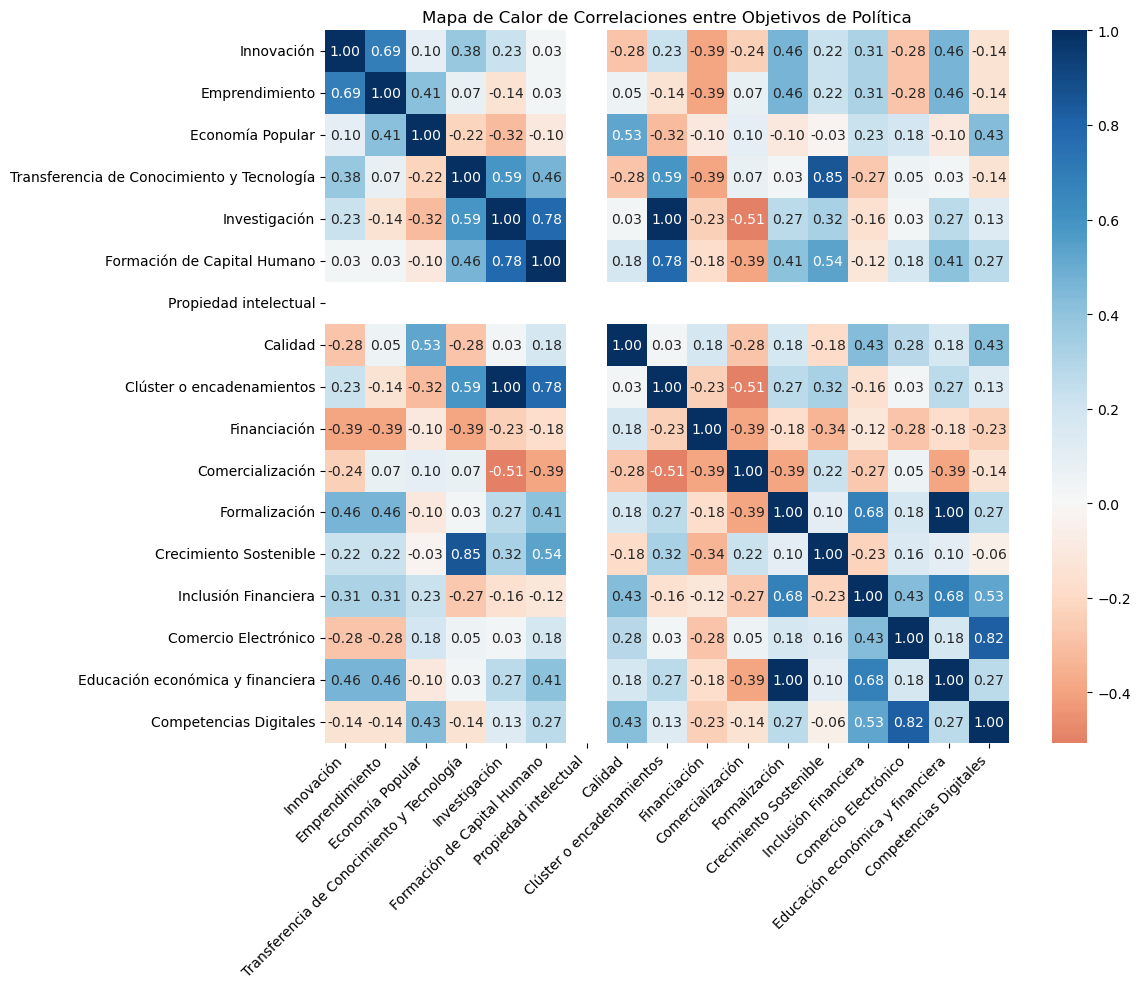


Estadísticas de correlaciones:
Correlación promedio: 0.103
Correlación máxima: 1.000
Correlación mínima: -0.507

Distribución de correlaciones:
Rango
Muy negativa          2
Negativa moderada    10
Negativa débil       32
Sin correlación      18
Positiva débil       27
Positiva moderada    17
Positiva fuerte      14
Name: count, dtype: int64


In [16]:
objetivos_politica = ["Innovación", "Emprendimiento", "Economía Popular", 
                               "Transferencia de Conocimiento y Tecnología", "Investigación", 
                               "Formación de Capital Humano", "Propiedad intelectual", "Calidad", 
                               "Clúster o encadenamientos", "Financiación", "Comercialización", 
                               "Formalización", "Crecimiento Sostenible", "Inclusión Financiera", 
                               "Comercio Electrónico", "Educación económica y financiera", 
                               "Competencias Digitales"]


obj_pol = prepare_data(data_arco, objetivos_politica)

def get_similar_by_support_type(instrument_name, top_n=5):
    """
    Encuentra instrumentos similares basados en el tipo de usuario.
    
    Parameters:
    instrument_name (str): Nombre del instrumento a comparar
    top_n (int): Número de recomendaciones a devolver
    
    Returns:
    DataFrame: Top N instrumentos similares con sus puntuaciones y detalles
    """
    # Verificar si el instrumento existe
    if instrument_name not in data_arco['Nombre del Instrumento'].values:
        return f"El instrumento '{instrument_name}' no se encuentra en la base de datos."
    
    # Obtener el índice del instrumento
    idx = data_arco[data_arco['Nombre del Instrumento'] == instrument_name].index[0]
    
    # Calcular matriz de similitud
    sim_matrix = cosine_similarity(obj_pol)
    
    # Obtener similitudes para el instrumento específico
    sim_scores = list(enumerate(sim_matrix[idx]))
    
    # Filtrar el instrumento mismo y ordenar por similitud
    sim_scores = [x for x in sim_scores if x[0] != idx]
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    
    # Obtener los top N más similares
    top_indices = [x[0] for x in sim_scores[:top_n]]
    top_scores = [x[1] for x in sim_scores[:top_n]]
    
    # Crear DataFrame con resultados detallados
    recommendations = pd.DataFrame({
        'Instrumento': data_arco['Nombre del Instrumento'].iloc[top_indices],
        'Puntuación de Similitud': [f"{score:.2%}" for score in top_scores]
    })
    
    # Agregar detalles de tipos de usuario para el instrumento original
    print(f"\nTipos de Objetivo para '{instrument_name}':")
    original_objetives = obj_pol.iloc[idx]
    for col, val in original_objetives.items():
        if val == 1:
            print(f"- {col}")
    
    # Agregar detalles para cada recomendación
    detailed_recommendations = []
    for i, idx in enumerate(top_indices):
        instrument_data = {
            'Instrumento': data_arco['Nombre del Instrumento'].iloc[idx],
            'Similitud': f"{top_scores[i]:.2%}",
            'Tipos de Objetivo': ', '.join([col for col, val in obj_pol.iloc[idx].items() if val == 1])
        }
        detailed_recommendations.append(instrument_data)
    
    detailed_df = pd.DataFrame(detailed_recommendations)
    
    return detailed_df

# Ejemplo de uso
instrumento = "Fábricas de Productividad y Sostenibilidad - Huila"
resultados = get_similar_by_support_type(instrumento)
print(f"\nInstrumentos más similares a '{instrumento}' según Objetivo de Política:")
print(resultados.to_string(index=False))

# Análisis adicional de la matriz de tipos de apoyo
print("\nEstadísticas de tipos de apoyo:")
user_type_stats = tip_apo.sum().sort_values(ascending=False)
print("\nNúmero de instrumentos por Objetivo de Política:")
for user_type, count in user_type_stats.items():
    print(f"{user_type}: {count}")

# Calcular correlaciones entre tipos de apoyo
#correlations = tip_apo.corr()
#print("\nCorrelaciones más fuertes entre tipos de apoyo:")
#for i in range(len(tipos_apoyo)):
#    for j in range(i+1, len(tipos_apoyo)):
#        corr = correlations.iloc[i,j]
#        if abs(corr) > 0.4:  # Mostrar solo correlaciones significativas
#            print(f"{tipos_apoyo[i]} - {tipos_apoyo[j]}: {corr:.3f}")


# Calcular correlaciones
correlations = obj_pol.corr()

# Mostrar todas las correlaciones ordenadas de mayor a menor
correlations_list = []
for i in range(len(objetivos_politica)):
    for j in range(i+1, len(objetivos_politica)):
        corr = correlations.iloc[i,j]
        correlations_list.append({
            'Tipo 1': objetivos_politica[i],
            'Tipo 2': objetivos_politica[j],
            'Correlación': corr
        })

# Convertir a DataFrame y ordenar
corr_df = pd.DataFrame(correlations_list)
corr_df = corr_df.sort_values('Correlación', ascending=False)

print("Todas las correlaciones ordenadas de mayor a menor:")
print(corr_df.to_string(index=False))

# Crear un mapa de calor para visualizar las correlaciones
plt.figure(figsize=(12, 10))
sns.heatmap(correlations, 
            annot=True, 
            cmap='RdBu', 
            center=0,
            fmt='.2f',
            xticklabels=objetivos_politica,
            yticklabels=objetivos_politica)
plt.title('Mapa de Calor de Correlaciones entre Objetivos de Política')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

# Análisis estadístico adicional
print("\nEstadísticas de correlaciones:")
print(f"Correlación promedio: {corr_df['Correlación'].mean():.3f}")
print(f"Correlación máxima: {corr_df['Correlación'].max():.3f}")
print(f"Correlación mínima: {corr_df['Correlación'].min():.3f}")

# Mostrar distribución de correlaciones por rangos
print("\nDistribución de correlaciones:")
ranges = [-1, -0.5, -0.3, -0.1, 0.1, 0.3, 0.5, 1]
labels = ['Muy negativa', 'Negativa moderada', 'Negativa débil', 
          'Sin correlación', 'Positiva débil', 'Positiva moderada', 'Positiva fuerte']
corr_df['Rango'] = pd.cut(corr_df['Correlación'], bins=ranges, labels=labels)
print(corr_df['Rango'].value_counts().sort_index())